This is a synthetic transactions dataset with fraud labels. EDA, fraud model building + thoughts below.

In [1]:
# For this notebook to run correctly these specific packages versions need to be installed:
# scikit-learn==0.23.2
# imbalanced-learn==0.7.0

import datetime
import folium
from folium.plugins import HeatMap, MarkerCluster
from geopy.distance import geodesic
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
import lightgbm
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from typing import Optional, Sequence

pd.set_option('display.max_columns', 500)
np.random.seed(1)

In [2]:
def class_proba_dist(df_summary: pd.DataFrame, bins: int = 30) -> None:
    """
    Plotting the class distribution of classifier probability outputs for the training and test set
    (raw counts and normalized)
    
        Parameters
        ----------
        df_summary:
            pd.DataFrame containing ground truth, output probability and train-test labels
        bins:
            number of bins of histogram
        
    """          
    subset_train = df_summary[df_summary['sample'] == 'train']
    subset_test = df_summary[df_summary['sample'] == 'test']

    unpack_cols = ['actual', 'pred']
    y_train, y_pred_train = subset_train[unpack_cols].values.T
    y_test, y_pred_test = subset_test[unpack_cols].values.T
    index_train_pos, index_train_neg  = (y_train == 1), (y_train == 0)
    index_test_pos, index_test_neg = (y_test == 1), (y_test == 0)

    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10,3), sharey='row')
    pd.Series(y_pred_train[index_train_neg]).hist(alpha=0.5, label='0', ax=ax1, bins=bins)
    pd.Series(y_pred_train[index_train_pos]).hist(alpha=0.5, label='1', ax=ax1, bins=bins)
    ax1.set_ylabel('count')
    ax1.set_title('train set')
    ax1.legend()
    pd.Series(y_pred_test[index_test_neg]).hist(alpha=0.5, label='0', ax=ax2, bins=bins)
    pd.Series(y_pred_test[index_test_pos]).hist(alpha=0.5, label='1', ax=ax2, bins=bins)
    ax2.set_title('test set')
    ax1.set_ylabel('count')
    ax2.legend();

    pd.Series(y_pred_train[index_train_neg]).hist(alpha=0.5, label='0', ax=ax3, density=True, bins=bins)
    pd.Series(y_pred_train[index_train_pos]).hist(alpha=0.5, label='1', ax=ax3, density=True, bins=bins)
    ax3.set_xlabel('clf output proba')
    ax3.set_ylabel('norm. count\n(arb. unit)')
    ax3.legend()
    pd.Series(y_pred_test[index_test_neg]).hist(alpha=0.5, label='0', ax=ax4, density=True, bins=bins)
    pd.Series(y_pred_test[index_test_pos]).hist(alpha=0.5, label='1', ax=ax4, density=True, bins=bins)
    ax4.set_xlabel('clf output proba')
    ax4.legend();
    plt.show()
    
    
def pr_curve(y_true: Sequence, y_pred: Sequence, baseline: Optional[float] = None) -> None:
    """
    Plotting the precision recall-curve with iso-f1 lines"
    
        Parameters
        ----------
        y_true:
            ground thruth data labels
        y_pred:
            classifier output probabilities 
        baseline:
            AUPRC baseline (most frequent class dummy classifier)
    """  
    plt.figure(figsize=(10,3))
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, color='b')

    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate(f'f1={f_score:0.1f}', xy=(0.9, y[45] + 0.02))

    if baseline is not None:
        plt.gca().axhline(baseline, c='r', ls='--')
        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontweight='bold', fontsize=12)
    plt.ylabel('Precision', fontweight='bold', fontsize=12)
    plt.show()

# EDA + feature engineering

In [3]:
use_cols = ['trans_time', 'cc_num', 'merchant', 'category', 'trans_amount', 
            'firstn', 'lastn', 'gender', 'street', 'city', 'state', 'zip',
            'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat', 'merch_long', 'is_fraud']
string_cols = ['merchant', 'category', 'firstn', 'lastn', 'gender', 'firstn', 
               'lastn', 'gender', 'street', 'city', 'state', 'zip', 'job']
dtypes = {k:'string' for k in string_cols}
dtypes.update({'cc_num':int,'city_pop':int})
df = pd.read_csv('transactions_data.csv', dtype=dtypes, 
                 parse_dates=['trans_time', 'dob'], usecols=use_cols)
# No timezone provided for the transaction time, so for simplicity's sake (US has several timezones!) 
# I'm going to assume it's the same across all dataset.

print("data shape: ", df.shape)
print("columns with missing data: ", df.isnull().sum()[df.isnull().sum() !=0]) # no missing data
print("proportion of duplicates in data: ", 
      round(df.duplicated().sum() / df.shape[0], 4), 
      f"({df.duplicated().sum()}/{df.shape[0]})")
# 3% duplicates

duplicates_fraud_prop = df.loc[df.duplicated(), 'is_fraud'].mean()
non_duplicates_fraud_prop = df.drop_duplicates()['is_fraud'].mean()
print("duplicated population fraud rate: ", round(duplicates_fraud_prop, 4))
print("non-duplicated population fraud rate: ", round(non_duplicates_fraud_prop, 4))

# The duplicate transactions don't appear to have a substantially different fraud rate than the rest of the data.
# If this were real data, during my analysis I would need to understand why these exist before I could confidently delete them 
# (e.g. they could be a symptom of a faulty database or data generating logic/code) 
# Here I create a "is duplicated in data" flag and delete duplicates: no information is lost.

df['is_duplicated'] = df.duplicated(keep=False).astype(int)
cols_dedup = [el for el in df.columns if (el != 'is_duplicated')]
print("size before dedup: ", df.shape)
df = df.drop_duplicates(subset=cols_dedup)
print("size after dedup: ", df.shape)
df = df.sort_values('trans_time').reset_index(drop=True) # this is a time series problem, i.e. non-iid samples
df['merchant'] = df['merchant'].str.replace('fraud_', '')

data shape:  (90767, 20)
columns with missing data:  Series([], dtype: int64)
proportion of duplicates in data:  0.0341 (3099/90767)
duplicated population fraud rate:  0.0187
non-duplicated population fraud rate:  0.0197
size before dedup:  (90767, 21)
size after dedup:  (87668, 21)


In [4]:
# Transaction time of day could potentially be a good indicator, e.g. more fraud at night?
df['time_of_day_transaction'] = df['trans_time'].apply(lambda x:x.replace(year=2000, month=1, day=1))
df['time_of_day_transaction_int'] = df['time_of_day_transaction'].dt.strftime("%H%M").astype(int) 
# Feature is not cyclical, but probably will be fine for tree based methods. 
# We might want to try a cos/sin encoding https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca

df['dob'] = pd.to_datetime(df['dob'])
df['customer_age_at_transaction'] = ((df['trans_time'].dt.date - df['dob'].dt.date).dt.days / 365).round()

# There appears to be significant problems with the city_pop column
df['city_pop_differs_from_median'] = df.groupby('city')['city_pop'].apply(lambda x: x != x.median()).astype(int)
print("proportion of total trans. where city_pop differs from median(city_pop): ", round(df['city_pop_differs_from_median'].sum() / df.shape[0], 4))

# Some of the worst offenders below
display(df.groupby('city')['city_pop_differs_from_median'].mean().sort_values(ascending=False).head().to_frame('prop. of trans. where city_pop differs from median'))
display(df.loc[df.city == 'Hampton', 'city_pop'].value_counts().to_frame('count').rename_axis('Hampton pop.'))

# For simplicity's sake, I'm going to work with the median value going forward
city2median_pop = df.groupby('city')['city_pop'].median().to_dict()
df['city_pop_median'] = df['city'].map(city2median_pop)

assert (df['trans_amount'] < 0).sum() == 0
assert (df['city_pop_median'] < 0).sum() == 0
df['trans_amount_log'] = df['trans_amount'].apply(lambda x: np.log(x+1))
df['city_pop_median_log'] = df['city_pop_median'].apply(lambda x: np.log(x+1))
df.head()

proportion of total trans. where city_pop differs from median(city_pop):  0.0281


prop. of trans. where city_pop differs from median
city                                                        
Hampton                                            1.000000 
Utica                                              0.715625 
Camden                                             0.668639 
Arcadia                                            0.608696 
Meridian                                           0.490862

count
Hampton pop.       
136895           40
2060             40

trans_time      cc_num                               merchant  \
0 2019-01-01 00:30:49  2063119439  Christiansen, Goyette and Schamberger   
1 2019-01-01 00:32:15  1332883884                            Lockman Ltd   
2 2019-01-01 00:59:25 -1013475192                             Harris Inc   
3 2019-01-01 01:09:57 -1138978499                   Rippin, Kub and Mann   
4 2019-01-01 01:34:10 -1980026442                       Smitham-Schiller   

        category  trans_amount  firstn     lastn gender  \
0  gas_transport         53.60   Vicki   Mendoza      F   
1    grocery_pos        212.75  Kelsey  Richards      F   
2  gas_transport         48.68  Taylor      Khan      F   
3       misc_net          3.79    Mary      Wall      F   
4    grocery_net         57.43  Regina  Johnston      F   

                        street               city state    zip      lat  \
0  3645 Atkins Island Apt. 238              Esbon    KS  66941  39.7562   
1  889 Sarah Station Suite 624            Holcomb    KS  67851  37.9931   
2      658 Diane Glen Apt. 677   North Washington    PA  16048  41.0472   
3              2481 Mills Lock         Plainfield    NJ   7060  40.6152   
4     641 Steven Mall Apt. 299  Westhampton Beach    NY  11978  40.8295   

       long  city_pop                     job        dob  merch_lat  \
0  -98.4462       242         Tourism officer 1987-07-18  40.332519   
1 -100.9893      2691         Arboriculturist 1993-08-16  38.862183   
2  -79.8089       139         Patent attorney 1954-05-25  40.237898   
3  -74.4150     71485  Leisure centre manager 1974-07-19  40.813669   
4  -72.6473      3255        Financial trader 1978-07-08  41.669034   

   merch_long  is_fraud  is_duplicated time_of_day_transaction  \
0  -99.062962     False              0     2000-01-01 00:30:49   
1 -101.234087     False              0     2000-01-01 00:32:15   
2  -79.894073     False              0     2000-01-01 00:59:25   
3  -75.283465     False              0     2000-01-01 01:09:57   
4  -73.271605     False              0     2000-01-01 01:34:10   

   time_of_day_transaction_int  customer_age_at_transaction  \
0                           30                         31.0   
1                           32                         25.0   
2                           59                         65.0   
3                          109                         44.0   
4                          134                         41.0   

   city_pop_differs_from_median  city_pop_median  trans_amount_log  \
0                             0            242.0          4.000034   
1                             0           2691.0          5.364807   
2                             0            139.0          3.905602   
3                             0          71485.0          1.566530   
4                             0           3255.0          4.067829   

   city_pop_median_log  
0             5.493061  
1             7.898040  
2             4.941642  
3            11.177257  
4             8.088255

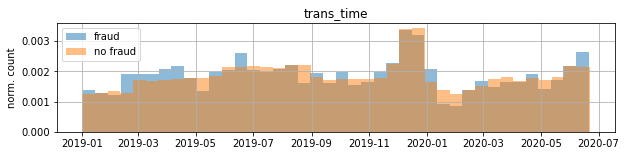

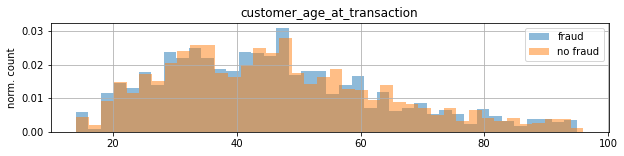

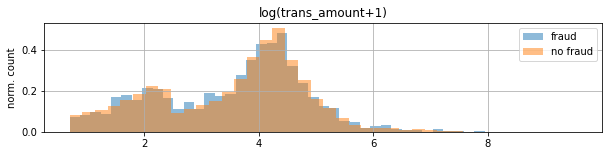

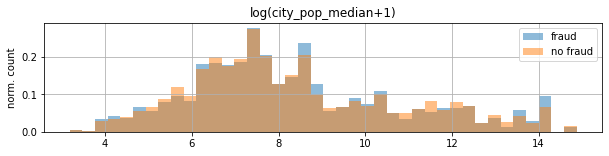

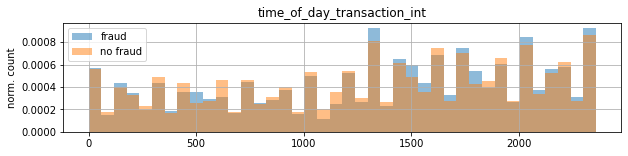

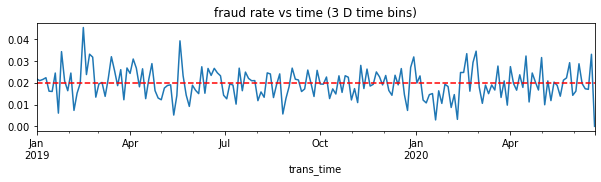

In [5]:
cat = ['merchant', 'category', 'firstn', 'lastn', 'gender', 'street', 'city', 'state', 'zip', 'job']
cont = ['trans_time', 'customer_age_at_transaction', 'trans_amount_log', 'city_pop_median_log', 
        'time_of_day_transaction_int']

func_title = {'trans_amount_log': 'log(trans_amount+1)', 'city_pop_median_log':'log(city_pop_median+1)'}
plot_kwargs = {'figsize':(10,2), 'alpha':0.5, 'density':True, 'bins':40}
for c in cont:
    df.loc[df['is_fraud'], c].hist(label='fraud', **plot_kwargs)
    df.loc[~df['is_fraud'], c].hist(label='no fraud', **plot_kwargs)
    plt.title(func_title.get(c, c))
    plt.ylabel('norm. count')
    plt.legend()
    plt.show()

delta_t = '3 D'
df.resample(delta_t, on='trans_time')['is_fraud'].mean().plot(figsize=(10,2))
plt.gca().axhline(df['is_fraud'].mean(), c='r', ls='--')
plt.title(f'fraud rate vs time ({delta_t} time bins)')
plt.show()

Takeaway:<br>
There is an uptick in transactions in dec 2019. This could be a transient event or the start of a new regime
(if new regime: we may need to build a 2020+ model only or exclude problematic weeks/months/data from the training set).<br>
The data shows the fraud rate didn't change during or after that period, in isolation I'm inclined to treat that as transient.

The rest of the features don't appear to show much univariate discriminatory power.
This likely means that a linear model created using these features,
without interaction terms and/or additional feature engineering, will perform poorly. 


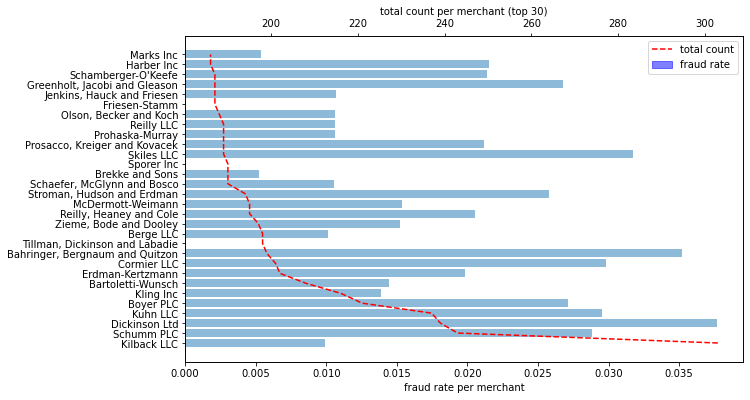

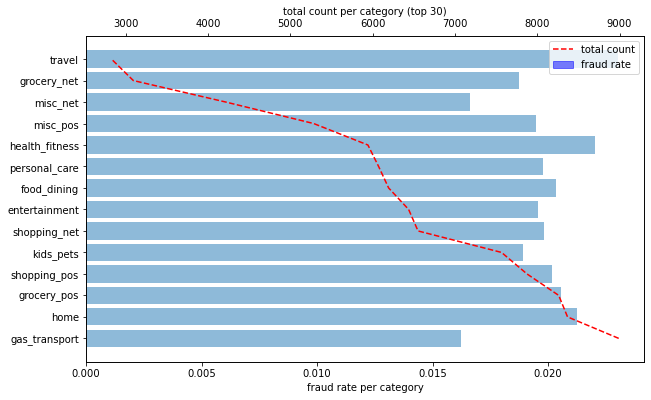

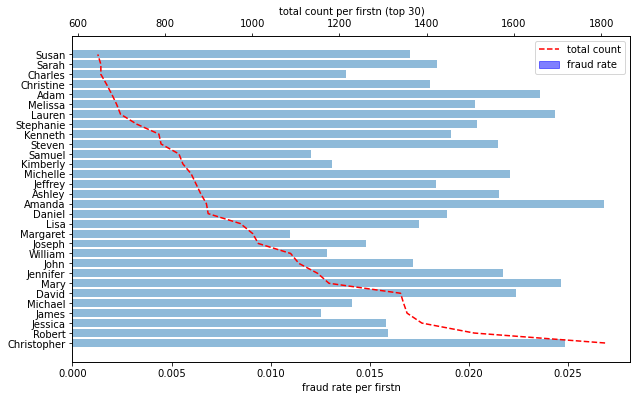

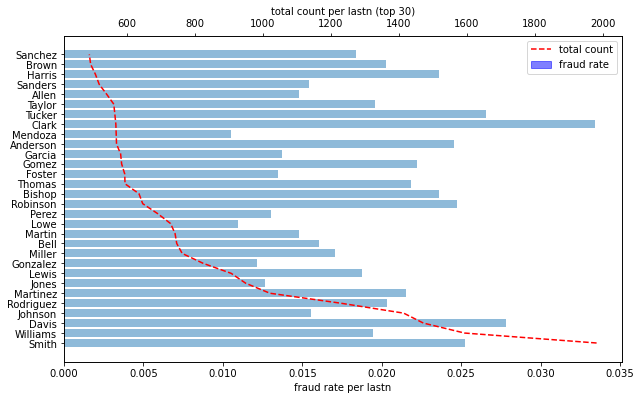

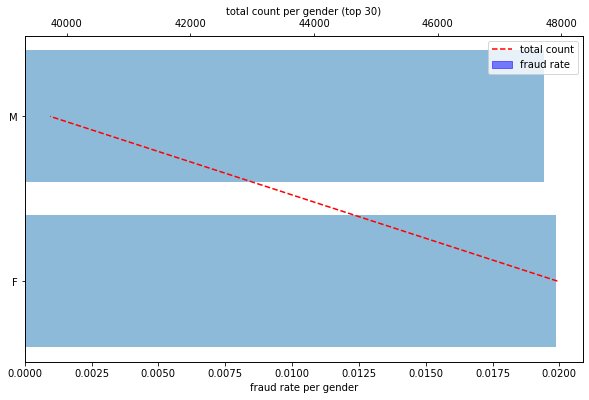

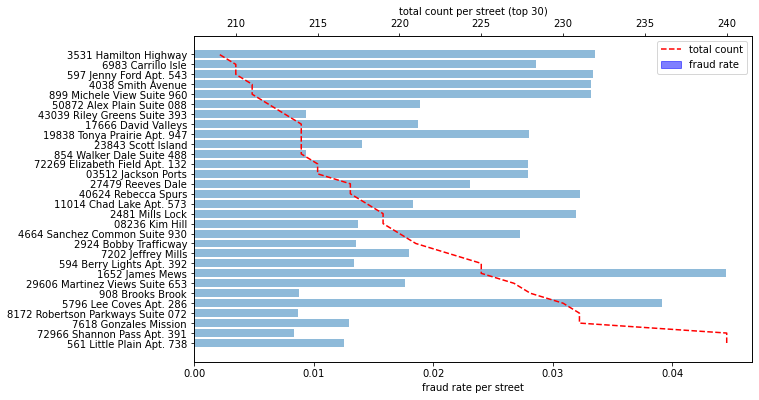

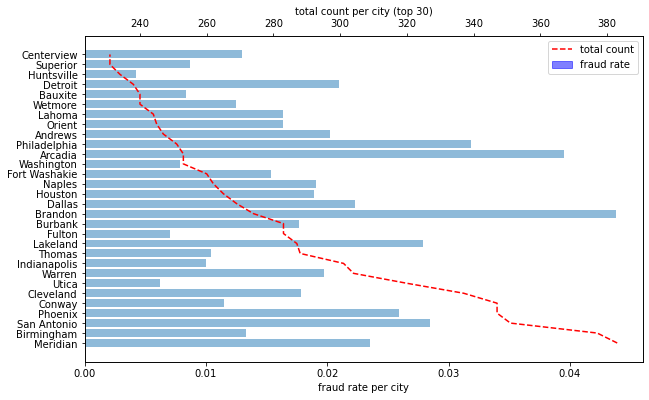

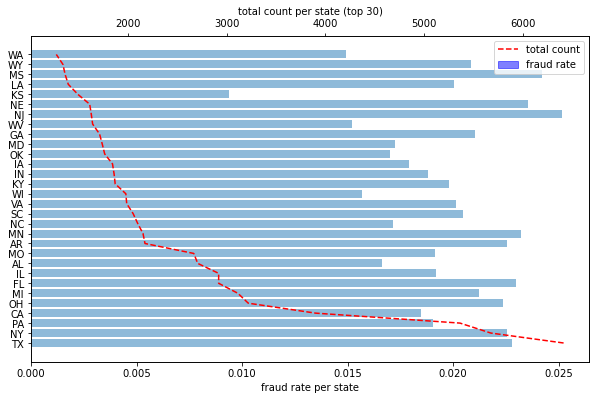

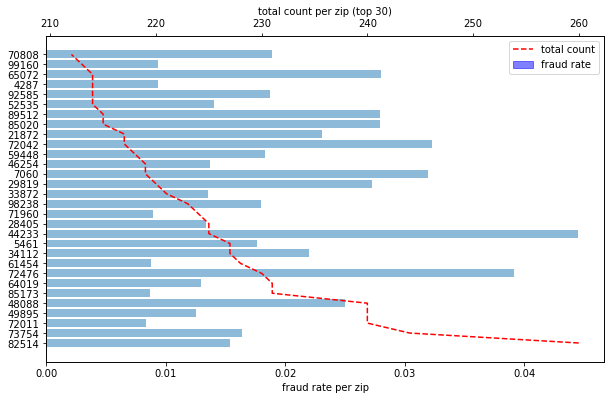

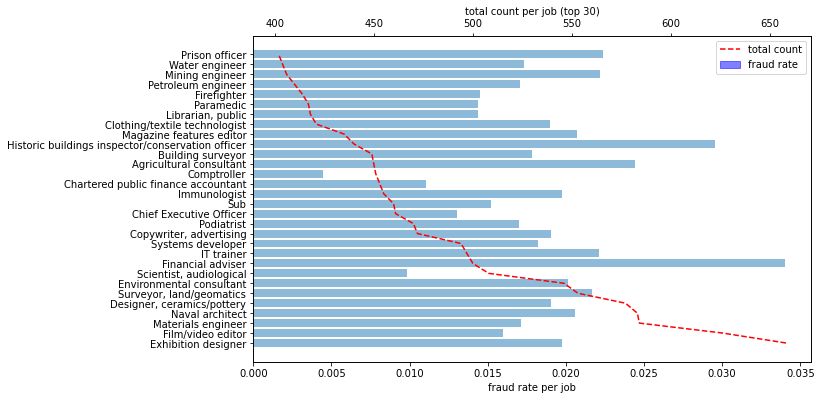

In [6]:
plot_kwargs = {'figsize':(10,4), 'alpha':0.4, 'kind':'barh'}
N = 30
for c in cat:
    top_cat = df[c].value_counts().index[:N]
    top_cat_index = df[c].isin(top_cat)
    plt.figure(figsize=(10,6))
    ax = plt.gca()
    ax.barh(top_cat, df.groupby(c)['is_fraud'].mean().reindex(top_cat), label='fraud rate', alpha=0.5)
    plt.xlabel(f'fraud rate per {c}')
    ax2 = ax.twiny()
    ax2.plot(df[c].value_counts().reindex(top_cat).values, top_cat, c='r', ls='--', label='total count')
    ax2.set_xlabel(f'total count per {c} (top {N})')
    plt.ylabel(c)
    
    patch = mpatches.Patch(color='blue', label='fraud rate', alpha=0.5)   
    # fix legend
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.extend([patch])
    plt.legend(handles=handles) 
    plt.show()

Takeaway:<br>
We look at the top30 most populated categories and see some pretty clear examples of fraud rate variation.<br>
Better be careful with those shifty Christophers, Davis's, Financial advisors, or people living in Brandon, 
they appear to have fraud rates up to twice as large as the average! 

In [7]:
# Additional feature engineering

df['cumulative_fraud_cc'] = df.groupby('cc_num')['is_fraud'].cumsum() 
# Cumulative fraudulent transactions per credit card
df['cumulative_no_fraud_cc'] = df.groupby('cc_num')['is_fraud'].apply(lambda x: (1-x).cumsum()) 
# Cumulative non-fraudulent transactions per credit card
df['average_fraud_rate_zip'] = df.groupby('zip')['is_fraud'].apply(lambda x:x.expanding().mean())
df['average_fraud_rate_city'] = df.groupby('city')['is_fraud'].apply(lambda x:x.expanding().mean())
df['cumulative_fraud_merch'] = df.groupby('merchant')['is_fraud'].cumsum() 
df['cumulative_fraud_rate_merch'] = df.groupby('merchant')['is_fraud'].apply(lambda x:x.expanding().mean())
df['number_frauds_last_60D_merch'] = df.groupby('merchant').apply(
    lambda x:x.rolling('60 D', on='trans_time')['is_fraud'].sum()).droplevel(0)
# Number of fraud at merchant for the last 60 days

# Address - cc_num link
df['address'] = df.street + ' ' + df.city + ' ' + df.zip.astype(str)
gby_cc_num = df.groupby('cc_num')
for c in ['street', 'city', 'zip', 'address']:
    print(f"# of credit cards associated with each {c}: ", df.groupby(c)['cc_num'].nunique().unique())

# Several addresses linked to different cards could have been a good predictor of fraud 
# This shows that there aren't enough unique cc_num per city (a limitation of the synthetic dataset)
# for that to be worth investigating further.

# of credit cards associated with each street:  [1]
# of credit cards associated with each city:  [1 2 3 4]
# of credit cards associated with each zip:  [1 2]
# of credit cards associated with each address:  [1]


In [8]:
coords_merch = df[['merch_lat', 'merch_long']].values
coords_transactions = df[['lat', 'long']].values

m = folium.Map(tuple(coords_transactions[0]), tiles='stamentoner', zoom_start=3)
HeatMap(coords_transactions).add_to(folium.FeatureGroup(name='transactions').add_to(m))
HeatMap(coords_merch).add_to(folium.FeatureGroup(name='merchants').add_to(m))
folium.LayerControl().add_to(m)
display(m)

# Takeaway:
# * If merchant outside in the US/in "suspicious" countries (e.g. Russia, Africa), could have been fraud indicator.
# * Merchant coordinates are located in the ocean / in the middle of the great lakes. Definitely an issue there.

# Creating a distance feature: 
# Since the analysis above shows me I can't trust the merchant location, I'm rounding it to the nearest 10 km
df['trans_merch_dist'] = df.apply(lambda x: geodesic((x['lat'], x['long']), 
                                                     (x['merch_lat'], x['merch_long'])).km, 1).round(-1)

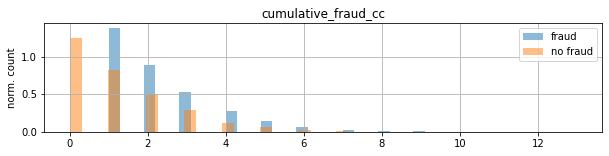

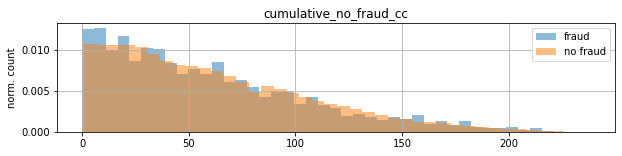

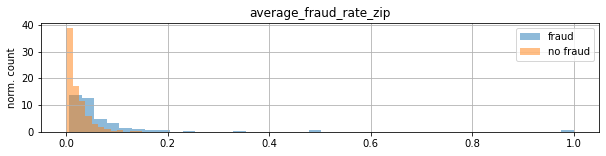

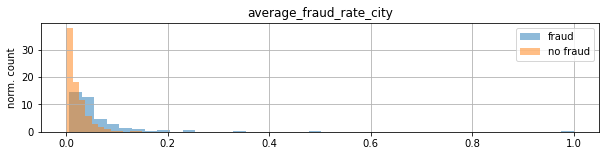

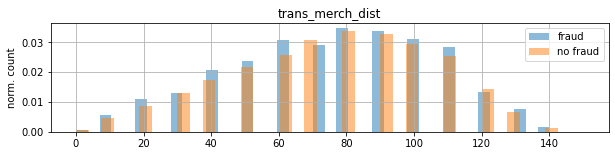

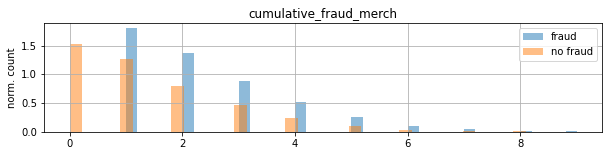

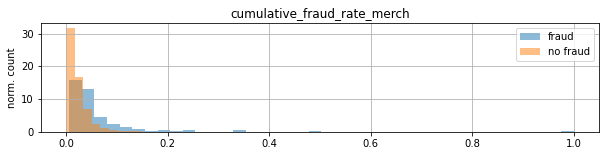

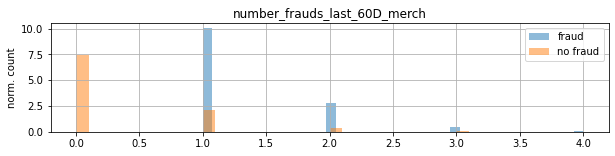

In [9]:
plot_kwargs = {'figsize':(10,2), 'alpha':0.5, 'density':True, 'bins':40}
cols = ['cumulative_fraud_cc', 'cumulative_no_fraud_cc', 'average_fraud_rate_zip', 
        'average_fraud_rate_city', 'trans_merch_dist', 'cumulative_fraud_merch', 
        'cumulative_fraud_rate_merch', 'number_frauds_last_60D_merch']
for c in cols:
    df.loc[df['is_fraud'], c].hist(label='fraud', **plot_kwargs)
    df.loc[~df['is_fraud'], c].hist(label='no fraud', **plot_kwargs)
    plt.title(c)
    plt.ylabel('norm. count')
    plt.legend()
    plt.show()
    
# Takeaway:
# There appears to be better class separation with some of these engineered features 
# (let's keep in mind that the normalised histogram hides the class imbalance)

# Model building

In [10]:
features = ['is_duplicated','time_of_day_transaction_int','customer_age_at_transaction','city_pop_differs_from_median',
'trans_amount_log','city_pop_median_log','cumulative_fraud_cc','cumulative_no_fraud_cc','average_fraud_rate_zip',
'average_fraud_rate_city','cumulative_fraud_merch','cumulative_fraud_rate_merch','number_frauds_last_60D_merch',
'trans_merch_dist']
cat_features = ['merchant', 'category', 'firstn', 'lastn', 'gender', 'street', 'city', 'state', 'zip', 'job']

assert df.trans_time.is_monotonic_increasing
train_size = 0.75
index_boundary = int(df.shape[0] * train_size)

In [11]:
X, y = df[features+cat_features], df['is_fraud'].astype(int)
X_train, y_train = X[:index_boundary], y[:index_boundary]
X_test, y_test = X[index_boundary:], y[index_boundary:]

assert (X_train.shape[0] + X_test.shape[0]) == X.shape[0]
assert (y_train.shape[0] + y_test.shape[0]) == y.shape[0]
assert X.shape[1] == X_train.shape[1]  == X_test.shape[1]
assert X.shape[1] == len(features) + len(cat_features)
assert len(y.shape) == 1

def count(x): return x.value_counts(dropna=False)
def proportion(x): return x.value_counts(normalize=True, dropna=False)
display(y_train.agg([count, proportion]).round(3).rename_axis('train'))
display(y_test.agg([count, proportion]).round(3).rename_axis('test'))

count  proportion
train                   
0      64449        0.98
1       1302        0.02

count  proportion
test                   
0     21494       0.981
1       423       0.019

In [12]:
tscv = TimeSeriesSplit(n_splits=4) # time series problem, we can't use a classic iid CV.

# SMOTE = nearest neighbour upsampling. Scaling the continuous features strikes me as a sensible thing to do 
# to make the feature space more isotropic.
# OHEing categoricals (/!\ this blows up the feature space)
preprocess = make_column_transformer(
    (StandardScaler(), features),
    (OneHotEncoder(handle_unknown='ignore'), cat_features)
)

pipe = Pipeline([('preprocess', preprocess),
                 ('downsampling', RandomUnderSampler()),
                 ('upsampling', SMOTE()),
                 ('clf', RandomForestClassifier())
                ])
pipe_params = {
    'downsampling__sampling_strategy': [0.6],
    'upsampling__sampling_strategy': [1],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [8,9]
}

grid = GridSearchCV(pipe, pipe_params, cv=tscv, verbose=4, n_jobs=-2, 
                    return_train_score=True, scoring='average_precision')
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   5 out of  16 | elapsed:    3.9s remaining:    8.8s
[Parallel(n_jobs=-2)]: Done  10 out of  16 | elapsed:    4.9s remaining:    2.9s
[Parallel(n_jobs=-2)]: Done  16 out of  16 | elapsed:    6.4s finished


{'clf__max_depth': 8, 'clf__n_estimators': 100, 'downsampling__sampling_strategy': 0.6, 'upsampling__sampling_strategy': 1}


av_prec_score  AUPRC baseline  improvement over baseline
train          0.226          0.0198                      11.40
test           0.105          0.0193                       5.45

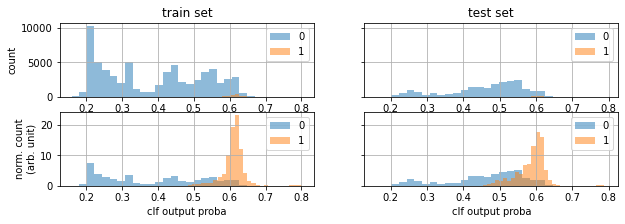

In [13]:
best_estimator = Pipeline([grid.best_estimator_.steps[0], grid.best_estimator_.steps[-1]])
df_summary = pd.DataFrame({'actual':y.tolist(),
                           'pred': best_estimator.predict_proba(X)[:,1],
                           'sample':y_train.shape[0] * ['train'] + y_test.shape[0] * ['test']
                          },index=y.index)
y_pred_train = best_estimator.predict_proba(X_train)[:,1]
y_pred_test = best_estimator.predict_proba(X_test)[:,1]

# scoring metric
aps_train = average_precision_score(y_train.tolist(), y_pred_train)
aps_test = average_precision_score(y_test.tolist(), y_pred_test)

# baseline comparison for AUPRC i.e. dummy classifier, always predict most frequent class
# https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/
basel_train = y_train.sum() / y_train.shape[0]
basel_test = y_test.sum() / y_test.shape[0]

df_scores = pd.DataFrame({'av_prec_score':[round(aps_train, 3), round(aps_test, 3)],
             'AUPRC baseline':[round(basel_train,4), round(basel_test,4)],
             'improvement over baseline':[round(aps_train/basel_train, 2), round(aps_test/basel_test, 2)]}, 
             index=['train', 'test'])
display(df_scores)
class_proba_dist(df_summary)

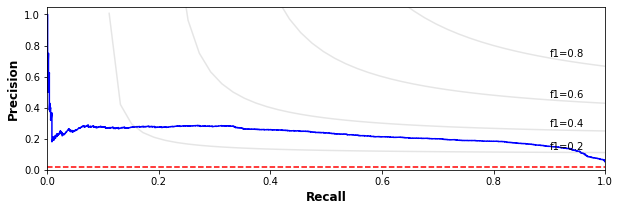

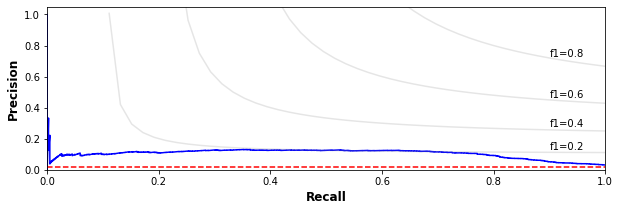

In [14]:
# PR curves
pr_curve(y_train.tolist(), y_pred_train, baseline=basel_train)
pr_curve(y_test.tolist(), y_pred_test, baseline=basel_test)

For imbalanced problems, typically models have trouble picking up the signal created by the minority class drowned in the majority. 
Here I take inspiration from the SMOTE article https://arxiv.org/pdf/1106.1813.pdf and do a majority class undersampling + minority oversampling to try to boost signal.
I started with a random forest model, easy to tune, fast and typically gets you a lot of mileage.
Note that RF are not expected to perform very well with a large amount of OHE'd features without deep trees like it is the case here.

In theory, I shouldn't be looking at the test set performance before selecting the final model.
In practice, I am doing that to get a rough sense of the model performance/generalisation capability.
As long as I don't push that peeking to the extreme i.e. "tune the model on the test set", I feel confident fending off angry statisticians attacks.

# More firepower

In [15]:
X, y = df[features+cat_features], df['is_fraud'].astype(int)

for c in cat_features:
    X[c] = X[c].astype('category')
    
X_train, y_train = X[:index_boundary], y[:index_boundary]
X_test, y_test = X[index_boundary:], y[index_boundary:]

assert (X_train.shape[0] + X_test.shape[0]) == X.shape[0]
assert (y_train.shape[0] + y_test.shape[0]) == y.shape[0]
assert X.shape[1] == X_train.shape[1]  == X_test.shape[1]
assert X.shape[1] == len(features) + len(cat_features)
assert len(y.shape) == 1

def count(x): return x.value_counts(dropna=False)
def proportion(x): return x.value_counts(normalize=True, dropna=False)
display(y_train.agg([count, proportion]).round(3).rename_axis('train'))
display(y_test.agg([count, proportion]).round(3).rename_axis('test'))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


count  proportion
train                   
0      64449        0.98
1       1302        0.02

count  proportion
test                   
0     21494       0.981
1       423       0.019

In [27]:
tscv = TimeSeriesSplit(n_splits=4)

params={
    'lambda_l1': (1e-10, 100.0, 'log-uniform'),
    'lambda_l2': (1e-10, 100.0, 'log-uniform'),
    'num_leaves': Integer(16, 100),
    'feature_fraction': Real(low=0.4, high=1., prior='uniform'),
    'bagging_fraction': Real(low=0.4, high=1., prior='uniform'),
    'bagging_freq': Integer(1, 7),
    'min_child_samples': Integer(7000, 10000),
}

cat_cols_formatted = ['name:'+el for el in cat_features]
lgbm_params = {'is_unbalance':'true', 'categorical_feature':cat_cols_formatted, 
               'n_jobs':-1,'verbose':0}
grid = BayesSearchCV(estimator=LGBMClassifier(**lgbm_params),
                search_spaces=params,
                n_iter=20,
                scoring='average_precision',
                refit=True,
                return_train_score=False,
                verbose=0,
                cv=tscv,
                n_jobs=-1
            )
grid.fit(X_train, y_train)
# grid.total_iterations
print(grid.best_params_)

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
categorical_feature in param dict is overridden.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0
[LightGBM] [Warning] bagging_fraction is set=0.8622724997137314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622724997137314
[LightGBM] [Warning] lambda_l2 is set=2.7651872230082445e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7651872230082445e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] categorical_feature is set=name:merchant,name:category,name:firstn,name:lastn,name:gender,name:street,name:city,name:state,name:zip,name:job, categorical_column=14,15,16,17,18,19,20,21,22,23 will be ignored. Current value: cate

av_prec_score  AUPRC baseline  improvement over baseline
train          0.347          0.0198                      17.52
test           0.166          0.0193                       8.59

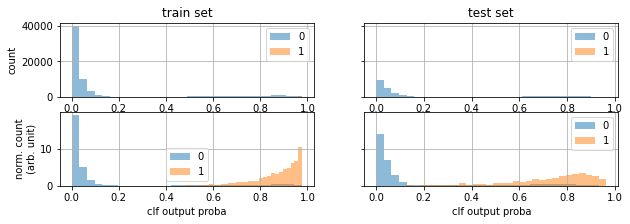

In [28]:
best_estimator = grid.best_estimator_
df_summary = pd.DataFrame({'actual':y.tolist(),
                           'pred': best_estimator.predict_proba(X)[:,1],
                           'sample':y_train.shape[0] * ['train'] + y_test.shape[0] * ['test']
                          },index=y.index)
y_pred_train = best_estimator.predict_proba(X_train)[:,1]
y_pred_test = best_estimator.predict_proba(X_test)[:,1]

aps_train = average_precision_score(y_train.tolist(), y_pred_train)
aps_test = average_precision_score(y_test.tolist(), y_pred_test)
basel_train =y_train.mean()
basel_test = y_test.mean()

df_scores = pd.DataFrame({'av_prec_score':[round(aps_train, 3), round(aps_test, 3)],
             'AUPRC baseline':[round(basel_train,4), round(basel_test,4)],
             'improvement over baseline':[round(aps_train/basel_train, 2), round(aps_test/basel_test, 2)]}, 
             index=['train', 'test'])
display(df_scores)
class_proba_dist(df_summary)

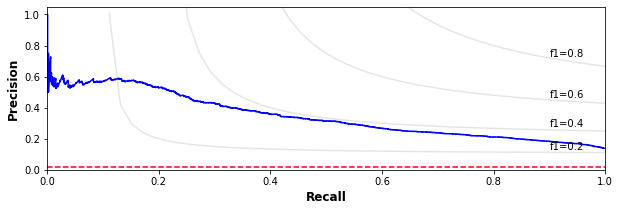

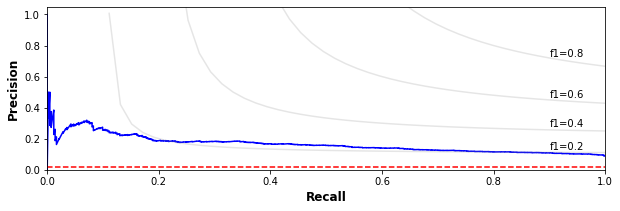

In [29]:
# PR curves
pr_curve(y_train.tolist(), y_pred_train, baseline=basel_train)
pr_curve(y_test.tolist(), y_pred_test, baseline=basel_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


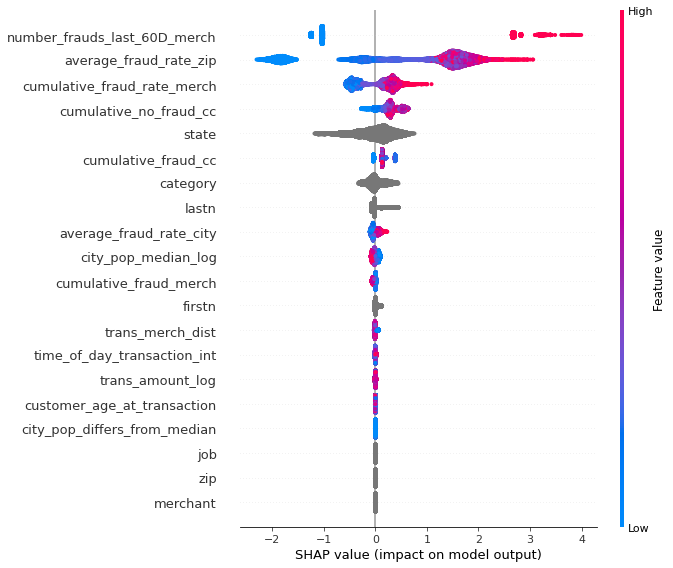

In [30]:
# ax = lightgbm.plot_importance(best_estimator, max_num_features=12)
# plt.show()
explainer = shap.TreeExplainer(best_estimator)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test) # explaining output of class 1 = fraud
plt.show()

For this second model iteration I wanted to go with one of the maintream gradient boosted trees models (e.g. XGBoost, LightGBM, Catboost...).
LightGBM happens to deal with categoricals and imbalanced data out of the box (*conditions apply), making my life easier.
I also substituted the simplistic GridSearchCV for a more refined hyperparameter search solution.<br>
I am happy my engineered features made it to the top.

# Discussion of results

Comparing the two models above, we see quite a bit of improvement when it comes to class separation using lightgbm. As it stands, they both overfit and have rather lackluster performance. This being a toy problem, I simply choose to stop my model tuning efforts here and select the second model iteration to go forward and dive a bit deeper.

A fraud tasks requires striking a balance between precision (amongst the transactions we identify as fraud, how many are actually fraudulent)
and recall (amongst all the fraudulent transactions, how many do we catch).<br>
If precision is too low, we are going to block too many legitimate transactions. 
If recall is too low, we are going to let through too many fraudulent transactions.

There are much toughts and work to be done around quantifying the cost of misclassification (FP/FN costs probably aren't symmetric), a lot of which depends on the specifics the business e.g. operations (cost of fraud review, transaction amount), trajectory/vision of the business (user experience/reputation, future user growth).

Here I select a "halfway house" threshold to go forward.

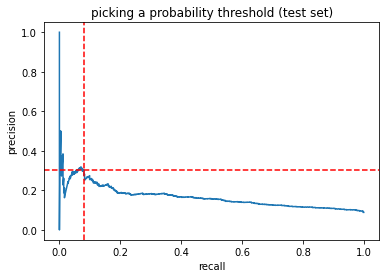

recall  precision  threshold
selected                              
test set    0.08      0.304      0.926

In [31]:
precision, recall, thresholds = precision_recall_curve(
    y_test, y_pred_test
)
pr_res = pd.DataFrame({'recall':recall[:-1], 'precision':precision[:-1]}, index=thresholds)
pr_res.name = 'thresholds'

# recall at precision >=0.3
selected_recall = pr_res.loc[pr_res['precision']>=0.3, 'recall'].max()
selected_precision = pr_res.loc[(pr_res['precision']>=0.3) & (pr_res['recall']==selected_recall), 'precision'].max()
selected_thresh = pr_res[(pr_res['precision']>=selected_precision) & (pr_res['recall']==selected_recall)].index[0]

plt.plot(recall, precision)
plt.gca().axvline(selected_recall,ls='--', c='r')
plt.gca().axhline(selected_precision, ls='--', c='r')
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('picking a probability threshold (test set)')
plt.show()

selected_stats = pd.DataFrame({'recall':[round(selected_recall, 3)],
             'precision':[round(selected_precision,3)],
             'threshold':[round(selected_thresh, 3)]}, 
             index=['test set'])#
display(selected_stats.rename_axis('selected'))

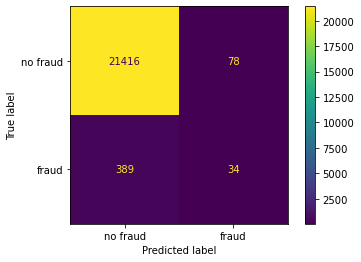

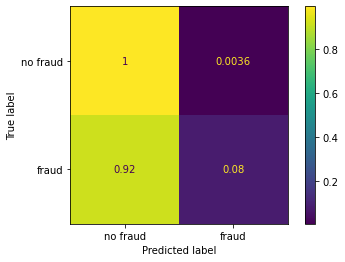

In [32]:
# overall performance - test set

clf_decision_test = [1 if el>=selected_thresh else 0 for el in  y_pred_test]
cm = confusion_matrix(y_test, clf_decision_test)
ConfusionMatrixDisplay(cm, display_labels=['no fraud', 'fraud']).plot()
plt.show()

cm = confusion_matrix(y_test, clf_decision_test, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['no fraud', 'fraud']).plot()
plt.show()

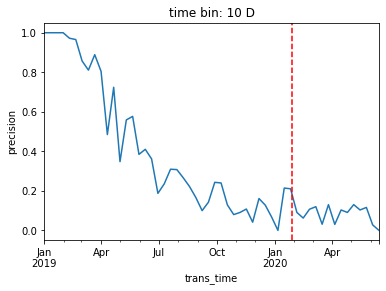

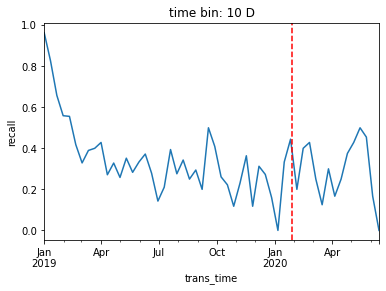

In [33]:
# performance vs time

df_perf = df_summary.join(df['trans_time'])
df_perf['predicted_class'] =  (df_perf['pred'] >= selected_thresh).astype(int)
df_perf['FP'] = ((df_perf['actual'] == 1) & (df_perf['predicted_class'] == 0)).astype(int)
df_perf['FN'] = ((df_perf['actual'] == 0) & (df_perf['predicted_class'] == 1)).astype(int)
df_perf['TP'] = ((df_perf['actual'] == 1) & (df_perf['predicted_class'] == 1)).astype(int)
df_perf['TN'] = ((df_perf['actual'] == 0) & (df_perf['predicted_class'] == 0)).astype(int)

def calc_recall(x): return x['TP']/(x['TP'] + x['FN'])
def calc_precision(x): return x['TP']/(x['TP'] + x['FP'])

date_train_test_boundary = df.loc[index_boundary, 'trans_time']
delta_t = '10 D' # time bin
df_resampled = df_perf.resample(delta_t,on='trans_time')
df_resampled[['TP', 'FP']].sum().apply(calc_precision, 1).plot()
# ax2 = plt.gca().twinx()
# df_resampled['TP'].count().plot(ax=ax2, c='orange')
plt.gca().axvline(date_train_test_boundary, c='r', ls='--')
plt.title(f'time bin: {delta_t}')
plt.ylabel('precision')
plt.show()
df_resampled[['TP', 'FN']].sum().apply(calc_recall, 1).plot()
# ax2 = plt.gca().twinx()
# df_resampled['TP'].count().plot(ax=ax2, c='orange')
plt.gca().axvline(date_train_test_boundary, c='r', ls='--')
plt.title(f'time bin: {delta_t}')
plt.ylabel('recall')
plt.show()

# the vertical red line separates train and test set data

As we can see, there is a sharp decrease of performance over time, the performance is not stable. I would have to dig deeper and understand why the model picks up signal better for these populations/dates.

While the performance appears to be unsatisfying, it's important to remember that a model isn't built in isolation. It should be compared to/evaluated against an existing solution (often a rule-based model if no ML has been done previously) to see if there is an improvement that can be exploited, e.g. wrt to a specific population segment.

# Discussion - next steps

There is a large amount of work to be done and many avenues to explore. What would I do if I had more time and this were real-world data?

### Preprocessing

- There are various kinds of target encodings to try (https://mattmotoki.github.io/beta-target-encoding.html could be worth exploring).
- As mentioned earlier, different feature transformations could lead to increased performance.
- More feature engineering! SHAP places my custom features at the top of the feature importance, let's create variations of them (esp. velocity features which typically play an important role in fraud tasks). 
- In additional to the above, this kind of data has inherently a graph structure/network effects which could be exploited (link analysis, transaction fraud vs merchant fraud).
- Anomaly score as a feature (e.g. isolation forest, autoencoder)?
- Perhaps sample weights decaying back in time (fraud is a fast changing landscape, more recent fraud patterns = more important signal to capture?).

### Algorithm
- More work on gbm/more computing power (Lightgbm has a large parameters list! https://sites.google.com/view/lauraepp/parameters).
- Ensembling (e.g. stacking models).
- Custom metric or loss function (penalising misclassified-large-amounts transactions, with a penalty weight cap).
- Deep learning for more complex models? RNN for fraud?

### Post-training analysis/metrics
- As mentioned, clarify the business constraints and translate them into an acceptable precision-recall tradeoff.
- Consider building models for different population segments (e.g. does fraud behaviour vary significantly by state?)
- Is this new model to be compared with an existing (rule-based?) fraud labelling system?
- Tree models tend to push output probabilites towards 0 and 1 i.e. under/over confident outputs which don't reflect the true class distribution. Does our use case warrant calibration? (risk-bucket approach vs simple discriminatory model).
- Model explainability/fairness: we could be dealing with black/grey box models in production. Do stakeholders want DS to be able to explain their inner working to some degree? (feature importance analysis, partial dependence plots, SHAP). For example, does it make sense to use first and last name as features? (in practice, do we want to penalise people named Christopher?)

### Thoughts on inference in production environment
- Real-time model performance monitoring issue: fraud can be reported for up to 120 days (and sometimes more), which means there will likely be lag in ground truth availability. What are good proxy metrics to quantify whether our model performs as intended? 
- Model needs to be fast (x*100ms?), that may restrict us to simpler models, or employ parallelisation/GPU (let's keep in mind that with enough feat. eng. and interaction terms logistic regression can go pretty far).
- Model prediction drift, covariate shift: how do we monitor, set alerting thresholds? (e.g. KS/chi-square tests)
- Retraining strategy/frequency? (online learning/warm start? retrain from scratch?).
- Model rollback procedure?
- Precision-recall tradeoff can be adjusted if environment changes (sudden onset of fraud -> ramp up recall?).

